# Tavily Search Power Demonstration

We will demonstrate what Tavily search can do by comparing two LangGraph agents:
1. **Basic Agent**: Using only chat gpt's knowledge without real-time search capabilities
2. **Tavily-Enhanced Agent**: Uses Tavily for real-time web search to provide current information

We'll see how Tavily transforms a limited AI agent into a powerful research assistant with access to current information.


In [1]:
# Importing all necessary libraries for our LangGraph agents
from typing import TypedDict, Annotated, Sequence, List
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, SystemMessage, BaseMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from tavily import TavilyClient
from dotenv import load_dotenv
import os

# Loading environment variables from .env file
load_dotenv()

print("✅ All libraries imported successfully!")
print("📝 Environment variables loaded from .env file")


✅ All libraries imported successfully!
📝 Environment variables loaded from .env file


## Agent State Definition

Both agents will use the same state structure to maintain conversation history and context. This allows for fair comparison between the two approaches.


In [2]:
class AgentState(TypedDict):
    """
    State structure for both agents.
    
    Fields:
    - messages: List of conversation messages with automatic message addition
    - search_results: Store search results for reference (used by Tavily agent)
    - query_count: Track how many queries have been processed
    """
    messages: Annotated[Sequence[BaseMessage], add_messages]
    search_results: str
    query_count: int

print("✅ Agent state structure defined")


✅ Agent state structure defined


## Tool Definitions

Here we define the tools that will be available to our agents. The basic agent will have no tools, while the Tavily agent will have access to real-time web search.


In [3]:
# Initialize Tavily client for web search capabilities
tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))

@tool
def tavily_search(query: str) -> str:
    """
    Search the web using Tavily for current, relevant information.
    
    This tool provides real-time access to web information, making the agent
    capable of answering questions about current events, recent developments,
    and any topic that requires up-to-date information.
    
    Args:
        query: The search query string
        
    Returns:
        Formatted search results from Tavily
    """
    try:
        # Perform the search using Tavily API
        # max_results=3 limits to top 3 most relevant results
        response = tavily_client.search(query=query, max_results=3)
        
        # Format the results for better readability
        if response and 'results' in response:
            formatted_results = []
            for i, result in enumerate(response['results'], 1):
                formatted_result = f"""
                Result {i}:
                Title: {result.get('title', 'N/A')}
                Content: {result.get('content', 'N/A')[:300]}...
                URL: {result.get('url', 'N/A')}
                """
                formatted_results.append(formatted_result)
            
            return "\n".join(formatted_results)
        else:
            return "No search results found."
            
    except Exception as e:
        return f"Search error: {str(e)}"

# Tool list for Tavily-enhanced agent
tavily_tools = [tavily_search]

print("✅ Tavily search tool defined and ready")


✅ Tavily search tool defined and ready


## Basic Agent (Without Tavily)

This agent relies only on its training data and has no access to current information. It demonstrates the limitations of AI without real-time data access.


In [4]:
# Initialize the basic model without tools
basic_model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

def basic_agent_node(state: AgentState) -> AgentState:
    """
    Basic agent node that processes user queries using only pre-trained knowledge.
    
    This agent has NO access to real-time information and can only respond
    based on what it learned during training. It will struggle with:
    - Current events
    - Recent developments
    - Real-time data
    - Recently changed information
    """
    
    # Create a system prompt that explains the agent's limitations
    system_prompt = SystemMessage(content="""
    You are a POWERFUL AI research assistant.
    
    Your capabilities include:
    - Access to current events and breaking news
    - Real-time data and statistics
    - Recent developments in any field
    - Up-to-date information on any topic
    
    Provide comprehensive, well-sourced answers..
    """)
    
    # Prepare messages for the model
    messages = [system_prompt] + list(state["messages"])
    
    # Get response from the basic model
    response = basic_model.invoke(messages)
    
    # Update the state with the new message and increment query count
    return {
        "messages": [response],
        "search_results": state.get("search_results", ""),
        "query_count": state.get("query_count", 0) + 1
    }

print("✅ Basic agent node created")


✅ Basic agent node created


## Tavily-Enhanced Agent

This agent has access to Tavily's real-time web search, making it capable of providing current, accurate information on any topic.


In [5]:
# Initialize the Tavily-enhanced model with search tools
tavily_model = ChatOpenAI(model="gpt-4o-mini", temperature=0).bind_tools(tavily_tools)

def tavily_agent_node(state: AgentState) -> AgentState:
    """
    Tavily-enhanced agent node that can search the web for current information.
    
    This agent has FULL access to real-time information through Tavily search:
    - Current events and news
    - Recent developments in any field
    - Real-time data and statistics
    - Up-to-date information on any topic
    
    The agent intelligently decides when to search based on the query type.
    """
    
    # Create a system prompt that explains the agent's enhanced capabilities
    system_prompt = SystemMessage(content="""
    You are a POWERFUL AI research assistant with access to real-time web search via Tavily.
    
    Your capabilities include:
    - Access to current events and breaking news
    - Real-time data and statistics
    - Recent developments in any field
    - Up-to-date information on any topic
    
    When to use Tavily search:
    - Questions about current events, news, or recent developments
    - Requests for latest data, statistics, or market information
    - Any query that might benefit from real-time information
    - When your training data might be outdated
    
    Always search first when the query involves:
    - "Current", "latest", "recent", "today", "now"
    - Specific dates after your training cutoff
    - Stock prices, weather, news, sports scores
    - Company updates, product releases, events
    
    Provide comprehensive, well-sourced answers using the search results.
    """)
    
    # Prepare messages for the model
    messages = [system_prompt] + list(state["messages"])
    
    # Get response from the Tavily-enhanced model
    response = tavily_model.invoke(messages)
    
    # Update the state with the new message and increment query count
    return {
        "messages": [response],
        "search_results": state.get("search_results", ""),
        "query_count": state.get("query_count", 0) + 1
    }

def should_continue_tavily(state: AgentState) -> str:
    """
    Determines whether the Tavily agent should continue processing (use tools) or end.
    
    The agent continues if the last message contains tool calls (i.e., wants to search),
    otherwise it ends the conversation.
    """
    
    messages = state["messages"]
    last_message = messages[-1]
    
    # Check if the last message has tool calls (search requests)
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "continue"  # Use tools (perform search)
    else:
        return "end"  # No tools needed, end conversation

print("✅ Tavily-enhanced agent node created")
print("🚀 This agent can access real-time web information!")


✅ Tavily-enhanced agent node created
🚀 This agent can access real-time web information!


## Graph Construction

Now we'll build both graphs using LangGraph. The basic graph has a simple linear flow, while the Tavily graph includes conditional logic for tool usage.


In [6]:
# Build the Basic Agent Graph (No Search Capabilities)
basic_graph = StateGraph(AgentState)

# Add the basic agent node
basic_graph.add_node("agent", basic_agent_node)

# Set entry point and simple flow to end
basic_graph.set_entry_point("agent")
basic_graph.add_edge("agent", END)

# Compile the basic graph
basic_app = basic_graph.compile()

print("✅ Basic agent graph compiled")

# Build the Tavily-Enhanced Agent Graph (With Search Capabilities)
tavily_graph = StateGraph(AgentState)

# Add nodes for the Tavily agent and tools
tavily_graph.add_node("agent", tavily_agent_node)
tavily_graph.add_node("tools", ToolNode(tavily_tools))

# Set entry point
tavily_graph.set_entry_point("agent")

# Add conditional edges based on whether tools are needed
tavily_graph.add_conditional_edges(
    "agent",
    should_continue_tavily,
    {
        "continue": "tools",  # If tools needed, go to tools node
        "end": END            # If no tools needed, end
    }
)

# After using tools, always go back to agent for final response
tavily_graph.add_edge("tools", "agent")

# Compile the Tavily graph
tavily_app = tavily_graph.compile()

print("✅ Tavily-enhanced agent graph compiled")



✅ Basic agent graph compiled
✅ Tavily-enhanced agent graph compiled


## Graph Visualization

Let's visualize both graphs to understand their structure and flow differences.


📈 Basic Agent Graph Structure:
Simple linear flow with no tool capabilities


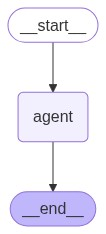


📈 Tavily-Enhanced Agent Graph Structure:
Conditional flow with tool integration capabilities


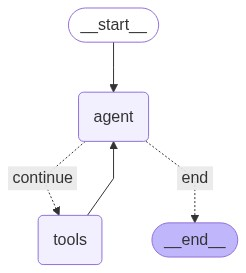

In [7]:
from IPython.display import Image, display
import matplotlib.pyplot as plt

print("📈 Basic Agent Graph Structure:")
print("Simple linear flow with no tool capabilities")
try:
    display(Image(basic_app.get_graph().draw_mermaid_png()))
except:
    print("Graph visualization not available, but structure is: START → Agent → END")

print("\n📈 Tavily-Enhanced Agent Graph Structure:")
print("Conditional flow with tool integration capabilities")
try:
    display(Image(tavily_app.get_graph().draw_mermaid_png()))
except:
    print("Graph visualization not available, but structure is: START → Agent → Tools (conditional) → Agent → END")


## Testing Helper Functions

These functions will help us test both agents with the same queries and compare their responses.


In [8]:
def test_basic_agent(query: str) -> dict:
    """
    Test the basic agent with a query and return the response.
    
    Args:
        query: The user's question or request
        
    Returns:
        Dictionary containing the agent's response and metadata
    """
    
    print(f"🤖 Testing Basic Agent with: '{query}'")
    print("-" * 60)
    
    # Create initial state
    initial_state = {
        "messages": [HumanMessage(content=query)],
        "search_results": "",
        "query_count": 0
    }
    
    # Run the basic agent
    result = basic_app.invoke(initial_state)
    
    # Extract and display the response
    response_content = result["messages"][-1].content
    print("📝 Basic Agent Response:")
    print(response_content)
    print("\n" + "="*60 + "\n")
    
    return {
        "query": query,
        "response": response_content,
        "agent_type": "Basic (No Search)",
        "has_search": False
    }

def test_tavily_agent(query: str) -> dict:
    """
    Test the Tavily-enhanced agent with a query and return the response.
    
    Args:
        query: The user's question or request
        
    Returns:
        Dictionary containing the agent's response and metadata
    """
    
    print(f"🚀 Testing Tavily-Enhanced Agent with: '{query}'")
    print("-" * 60)
    
    # Create initial state
    initial_state = {
        "messages": [HumanMessage(content=query)],
        "search_results": "",
        "query_count": 0
    }
    
    # Run the Tavily-enhanced agent
    result = tavily_app.invoke(initial_state)
    
    # Extract response and check if search was used
    response_content = result["messages"][-1].content
    
    # Check if any tool calls were made
    search_used = any(
        hasattr(msg, "tool_calls") and msg.tool_calls 
        for msg in result["messages"]
    )
    
    print("📝 Tavily Agent Response:")
    print(response_content)
    
    if search_used:
        print("\n🔍 Search was performed to get real-time information!")
    else:
        print("\n💭 No search needed - answered from existing knowledge")
    
    print("\n" + "="*60 + "\n")
    
    return {
        "query": query,
        "response": response_content,
        "agent_type": "Tavily-Enhanced",
        "has_search": True,
        "search_used": search_used
    }

def compare_agents(query: str):
    """
    Test both agents with the same query and display a comparison.
    
    This function demonstrates the key differences between an agent
    with and without real-time search capabilities.
    """
    
    print("🔄 AGENT COMPARISON")
    print(f"Query: '{query}'")
    print("="*80)
    
    # Test both agents
    basic_result = test_basic_agent(query)
    tavily_result = test_tavily_agent(query)
    
    # Summary comparison
    print("📊 COMPARISON SUMMARY:")
    print(f"Basic Agent: Limited to training data, {'cannot' if 'current' in query.lower() or 'latest' in query.lower() else 'may'} provide current info")
    print(f"Tavily Agent: {'Used real-time search' if tavily_result.get('search_used', False) else 'Answered from knowledge'} - Always has access to current data")
    
    return basic_result, tavily_result

print("✅ Testing helper functions ready")


✅ Testing helper functions ready


## Demonstration 1: Current Events Query

Let's test both agents with a current events question to see the dramatic difference in capabilities.


In [9]:
# Test with a current events query
current_events_query = "What are the latest developments in artificial intelligence this week?"

basic_result_1, tavily_result_1 = compare_agents(current_events_query)


🔄 AGENT COMPARISON
Query: 'What are the latest developments in artificial intelligence this week?'
🤖 Testing Basic Agent with: 'What are the latest developments in artificial intelligence this week?'
------------------------------------------------------------
📝 Basic Agent Response:
As of the week of October 23, 2023, several notable developments in artificial intelligence have emerged:

1. **AI Regulation Discussions**: Governments and regulatory bodies are intensifying discussions around AI regulations. The European Union is moving forward with its AI Act, which aims to establish a comprehensive framework for AI governance. This week, there were significant debates regarding the classification of AI systems and the responsibilities of developers and users.

2. **Advancements in Generative AI**: Companies like OpenAI and Google have announced updates to their generative AI models. OpenAI's ChatGPT has seen improvements in its ability to understand context and generate more nuanced re

## Demonstration 2: Market Information Query

Let's test with a market/financial query that requires real-time data.


In [10]:
# Test with a market information query
market_query = "What is the current stock price of Tesla and any recent news about the company?"

basic_result_2, tavily_result_2 = compare_agents(market_query)


🔄 AGENT COMPARISON
Query: 'What is the current stock price of Tesla and any recent news about the company?'
🤖 Testing Basic Agent with: 'What is the current stock price of Tesla and any recent news about the company?'
------------------------------------------------------------
📝 Basic Agent Response:
I currently do not have real-time access to stock prices or live news updates. However, you can easily find the current stock price of Tesla (TSLA) by checking financial news websites, stock market apps, or platforms like Google Finance, Yahoo Finance, or Bloomberg.

As for recent news about Tesla, I can provide a summary based on information available up to October 2023. Tesla has been focusing on expanding its production capabilities, particularly with the ramp-up of its Gigafactories in Texas and Berlin. The company has also been making headlines with its advancements in autonomous driving technology and updates regarding its Full Self-Driving (FSD) software.

Additionally, Tesla has b

## Demonstration 3: Technology Trends Query

Let's test with a technology trends question to see how each agent handles recent developments.


In [11]:
# Test with a technology trends query
tech_query = "What are the most recent breakthroughs in quantum computing in 2025?"

basic_result_3, tavily_result_3 = compare_agents(tech_query)


🔄 AGENT COMPARISON
Query: 'What are the most recent breakthroughs in quantum computing in 2025?'
🤖 Testing Basic Agent with: 'What are the most recent breakthroughs in quantum computing in 2025?'
------------------------------------------------------------
📝 Basic Agent Response:
I currently do not have access to information beyond October 2023, so I cannot provide details on breakthroughs in quantum computing that may have occurred in 2025. However, I can summarize some of the key trends and developments in quantum computing up to 2023, which may help you understand the trajectory of the field.

1. **Error Correction**: Significant advancements were made in quantum error correction techniques, which are crucial for building reliable quantum computers. Researchers developed new algorithms and architectures that improve the fidelity of quantum operations.

2. **Quantum Supremacy**: In 2022, Google and other organizations continued to explore the implications of quantum supremacy, where 

## Demonstration 4: General Knowledge Query

Let's also test with a general knowledge question to see how both agents perform when current information isn't strictly necessary.


In [12]:
# Test with a general knowledge query
general_query = "Explain the concept of machine learning and its main types"

basic_result_4, tavily_result_4 = compare_agents(general_query)


🔄 AGENT COMPARISON
Query: 'Explain the concept of machine learning and its main types'
🤖 Testing Basic Agent with: 'Explain the concept of machine learning and its main types'
------------------------------------------------------------
📝 Basic Agent Response:
Machine learning (ML) is a subset of artificial intelligence (AI) that focuses on the development of algorithms and statistical models that enable computers to perform tasks without explicit instructions. Instead of being programmed to perform a specific task, machine learning systems learn from data, identify patterns, and make decisions based on that data. The primary goal of machine learning is to enable computers to improve their performance on a task over time as they are exposed to more data.

### Main Types of Machine Learning

Machine learning can be broadly categorized into three main types:

1. **Supervised Learning**:
   - **Definition**: In supervised learning, the model is trained on a labeled dataset, which means th

## Interactive Testing Section

Lets test with anything we got 


In [14]:
# Lets test with whatever
your_query = "What is an alt coin that is trending right now (2025 July)that I could invest in to make some greens"


basic_result_custom, tavily_result_custom = compare_agents(your_query)


🔄 AGENT COMPARISON
Query: 'What is an alt coin that is trending right now (2025 July)that I could invest in to make some greens'
🤖 Testing Basic Agent with: 'What is an alt coin that is trending right now (2025 July)that I could invest in to make some greens'
------------------------------------------------------------
📝 Basic Agent Response:
I currently do not have access to real-time data or events beyond October 2023, so I cannot provide specific information about altcoins trending in July 2025. However, I can offer some general advice on how to identify promising altcoins for investment:

1. **Market Research**: Look for altcoins that have strong fundamentals, such as a solid use case, a dedicated development team, and a clear roadmap.

2. **Community Engagement**: Check the community support on platforms like Reddit, Twitter, and Discord. A strong, active community can be a good indicator of an altcoin's potential.

3. **Technological Innovation**: Consider coins that are introduc

## Conclusion

This demonstration clearly shows the transformative power of Tavily search integration:

### Without Tavily:
- Agents are limited to training data
- Cannot access current information
- Often must admit limitations
- May provide outdated information

### With Tavily:
- Agents become powerful research assistants
- Real-time access to current information
- Can provide sourced, up-to-date answers
- Intelligent decision-making about when to search

**Tavily doesn't just add search capability - it fundamentally transforms what an AI agent can accomplish, making it exponentially more useful for real-world applications.**

## We could: 

- Implement different search strategies
- Combine multiple information sources
- Add result filtering and ranking
- Create domain-specific search agents
to further improve our agent
